# Tasks

* Implement vanilla autoencoder
* Train it on MNIST dataset MNIST
* Display digits recovered dy AE
* Display distribution of embeddings in latent space

#Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples.

The images were centered in a 28x28 image by computing the center of mass of the pixels.



In [88]:
import random, os
import numpy as np
import torch

# фиксируем сид
# https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964
def seed_everything(seed: int):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True
  
seed_everything(122)

In [89]:
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms, utils

MEAN = 0.1307
STD = 0.3081

transf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(MEAN, STD)
])

train_dataset = MNIST('mnist', train=True, download=True, transform=transf)
test_dataset = MNIST('mnist', train=False, download=True, transform=transf)

Display some samples along with corresponding labels

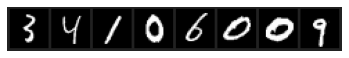

[3 4 1 0 6 0 0 9]


In [118]:
import matplotlib.pyplot as plt
from torch.utils.data import  DataLoader

# Helper method
def show(grid):
  plt.axis("off")
  # вообщето показывать картинки после нормализации это не самая лучшая идея
  # поэтому я тут реверсию нормализацию
  grid = torch.clamp(grid * STD + MEAN, 0, 1).permute(1,2,0).numpy()
  plt.imshow(grid)
  plt.show()    

vis_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter) # img1,  label

# display the data
grid = torchvision.utils.make_grid(example_batch[0])
show(grid)
print(example_batch[1].numpy())

# Model

Implement vanilla autoencoder model.

Чиселки у меня все взяты с вот этой картинки, которая у нас кажется на лекции была😎

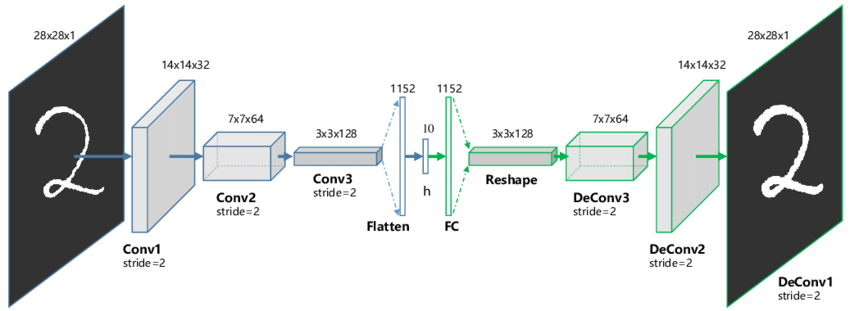

In [91]:
import torch.nn as nn

# у меня тут конвалюционная сеть с тремя конволюциями и одним полным слоём
IMAGE_SIZE = 28
CONV_CHANNELS = [32, 64, 128]
CONV_SIZE = int(IMAGE_SIZE/2**len(CONV_CHANNELS))  # размер последнего конволюционного слоя = 3
LINEAR_FEAT = CONV_CHANNELS[-1] * CONV_SIZE**2  # размер линейного слоя = 1152

class Encoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.latent_size = latent_size

    # собираем по кусочкам
    layers = []
    for in_c, out_c in zip([1]+CONV_CHANNELS[:-1], CONV_CHANNELS):
      layers.append(nn.Conv2d(in_c, out_c, kernel_size=2, stride=2))
      layers.append(nn.BatchNorm2d(out_c))
      layers.append(nn.ReLU())
    layers.append(nn.Flatten())

    self.conv = nn.Sequential(*layers)
    self.linear = nn.Linear(in_features=LINEAR_FEAT, out_features=latent_size)

  def forward(self, x):
    return self.linear(self.conv(x))


class Decoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.latent_size = latent_size

    self.linear = nn.Linear(in_features=latent_size, out_features=LINEAR_FEAT)

    # собираем по кусочкам, только в обратном порядке
    layers = []
    for out_c, in_c in list(zip([1]+CONV_CHANNELS[:-1], CONV_CHANNELS))[::-1]:
      # костыль: поскольку 28 не делиться на 2**3 размеры слоёв приходиться округлять
      # doconv и conv слои округляют их поразному, и поэтому размер выходной картинки получается 24х24
      # поэтому надо крутить kernel_size=3, то только в одном из слоёв
      k_size = 3 if in_c == CONV_CHANNELS[-1] else 2
      layers.append(nn.ReLU())
      layers.append(nn.ConvTranspose2d(in_c, out_c, kernel_size=k_size, stride=2))
      layers.append(nn.BatchNorm2d(out_c))
    self.conv = nn.Sequential(*layers)
  
  def forward(self, x):
    shape = (x.shape[0], CONV_CHANNELS[-1], CONV_SIZE, CONV_SIZE)
    reshaped = torch.reshape(self.linear(x), shape)
    return self.conv(reshaped)

##Smoke test 

In [92]:
encoder = Encoder(2)
dummy = torch.randn((1,1,28,28))
print("Encoder In", dummy.shape)
embedding = encoder(dummy)
print("Encoder Out", embedding.shape)


decoder = Decoder(2)
recovered = decoder(embedding)
print("Decoder out", recovered.shape)

assert dummy.shape == recovered.shape, "Decoder out shape must be equal to input shape"

Encoder In torch.Size([1, 1, 28, 28])
Encoder Out torch.Size([1, 2])
Decoder out torch.Size([1, 1, 28, 28])


###AE

Implement AutoEncoder class. 
Use Decoder and Encoder classes implemented early.

In [93]:
class AutoEncoder(nn.Module):
  def __init__(self, latent_size):
    super().__init__()
    self.latent_size = latent_size
    self.encoder = Encoder(latent_size)
    self.decoder = Decoder(latent_size)

  def forward(self, x):
    embedding = self.encoder(x)
    recovered_x = self.decoder(embedding)
    return recovered_x, embedding

# Train

Tensorboard launching code



In [ ]:
import os
import shutil
import tensorflow as tf
import tensorboard as tb

#https://stackoverflow.com/questions/60730544/tensorboard-colab-tensorflow-api-v1-io-gfile-has-no-attribute-get-filesystem
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

# Helper method to run Tensorboard in Colab
def reinit_tensorboard(clear_log = True):
  # Directory for log files
  logs_base_dir = "runs"
  if clear_log:
    # Clear logs
    shutil.rmtree(logs_base_dir, ignore_errors = True)
    os.makedirs(logs_base_dir, exist_ok=True)
  # Colab magic
  %load_ext tensorboard
  %tensorboard --logdir {logs_base_dir}

reinit_tensorboard()

Define dataloaders

In [95]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=256)

In [96]:
# смотрим на (диз)баланс классов
from collections import Counter

print(*zip(train_dataset.classes, Counter(train_dataset.targets.numpy()).values()))
print(*zip(test_dataset.classes, Counter(test_dataset.targets.numpy()).values()))

('0 - zero', 5421) ('1 - one', 5923) ('2 - two', 5842) ('3 - three', 6742) ('4 - four', 5949) ('5 - five', 5958) ('6 - six', 6131) ('7 - seven', 5918) ('8 - eight', 6265) ('9 - nine', 5851)
('0 - zero', 1028) ('1 - one', 1032) ('2 - two', 1135) ('3 - three', 980) ('4 - four', 982) ('5 - five', 1009) ('6 - six', 892) ('7 - seven', 958) ('8 - eight', 1010) ('9 - nine', 974)


Тут конечно всё хорошо, это же знаменитый MNIST😳

Define main training routine and train your model

In [97]:
from torch import optim
from torch.utils.tensorboard import SummaryWriter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(repr(device))
model = AutoEncoder(10)
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
writer = SummaryWriter(comment="basic CNN 10", flush_secs=3)

device(type='cuda')


In [98]:
# функции для тринеровки
from tqdm import tqdm
from typing import Tuple

def log_images(prefix: str, epoch: int, imgs, reconstructed, limit=8):
  images = torch.cat([imgs[:limit], reconstructed[:limit]], dim=0)
  images = torch.clamp(images * STD + MEAN, 0, 1)
  grid = torchvision.utils.make_grid(images, nrow=limit)
  writer.add_image(f"{prefix}/images", grid, epoch)

def train_epoch(epoch: int) -> Tuple[str, int, float, list]:
  model.train()
  losses = [] 

  for img_batch, _ in tqdm(train_dataloader, desc=f"Epoch {epoch:03}: Training"):    
    imgs = img_batch.to(device)

    optimizer.zero_grad()
    reconstructed, embedding = model(imgs)
    loss = criterion(reconstructed, imgs)
    
    loss.backward()
    optimizer.step()

    losses.append(loss.item() * imgs.shape[0])
  
  log_images("train", epoch, imgs, reconstructed)

  return "train", epoch, np.mean(losses), losses

def predict(epoch: int, model) -> Tuple[str, int, float, list]:
  model.eval()
  losses = [] 
  
  with torch.no_grad():
    for img_batch, _ in tqdm(test_dataloader, desc=f"Epoch {epoch:03}: Predict "):
      imgs = img_batch.to(device)
      reconstructed, embedding = model(imgs)
      loss = criterion(reconstructed, imgs)
      losses.append(loss.item() * imgs.shape[0])

  log_images("val", epoch, imgs, reconstructed)

  return "val", epoch, np.mean(losses), losses

def log_scores(prefix: str, epoch: int, loss: float, losses: list):
  writer.add_scalar(f"{prefix}/epoch loss", loss, epoch)
  for i, val in enumerate(losses):
    writer.add_scalar(f"{prefix}/step loss", val, i + epoch*len(losses))

def train(epochs: int = 30):
  seed_everything(69)
  for epoch in range(epochs):
    log_scores(*train_epoch(epoch))
    log_scores(*predict(epoch, model))


In [ ]:
# сама получается тренировка
train()

## Let's test the model

Compare original and recovered digits.

Original:


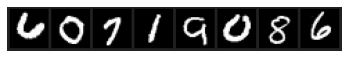

Reconstructed:


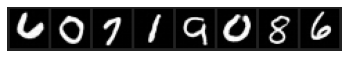

tensor([6, 0, 7, 1, 9, 0, 8, 6])


In [106]:
def demo_autoencoder():
  orig, labels = next(dataiter)

  # display the data
  print("Original:")
  original = torchvision.utils.make_grid(orig)
  show(original)

  print("Reconstructed:")
  reconstructed = torchvision.utils.make_grid(model(orig.to(device))[0])
  show(reconstructed.cpu())
  print(labels)

demo_autoencoder()

Show embeddings positions in latent space

In [101]:
from sklearn.manifold import TSNE

with torch.no_grad():
  mega_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
  all_images, all_labels = next(iter(mega_loader))
  _, embeddings = model(all_images.to(device))
  visual = TSNE(learning_rate='auto', init='random', n_jobs=-1).fit_transform(embeddings.cpu())

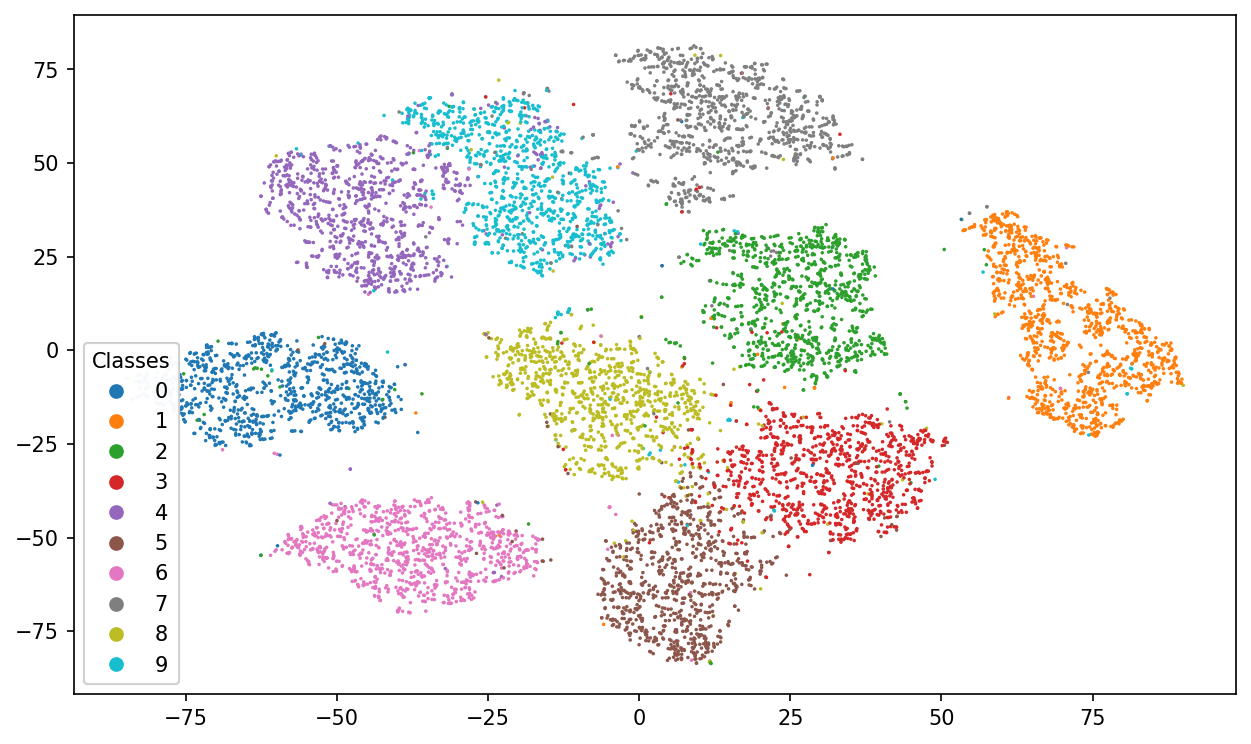

In [102]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)

scatter = ax.scatter(visual[:,0], visual[:,1], c=all_labels, s=0.5, cmap="tab10")

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="lower left", title="Classes")
ax.add_artist(legend1)

plt.show()

# Посик оптимальной модели

In [103]:
def reset_model(embed_size=10, lr=1e-2):
  global model, optimizer, writer
  model = AutoEncoder(embed_size)
  model.to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  writer = SummaryWriter(comment=f"embed{embed_size} lr{lr}", flush_secs=3)

In [ ]:
# пробуем разные размеры
reset_model(2)
train()
reset_model(5)
train()
reset_model(15)
train(10)
reset_model(20)
train(10)
reset_model(25)
train()
reset_model(50)
train()

In [ ]:
reinit_tensorboard(False)

Original:


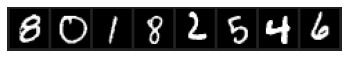

Reconstructed:


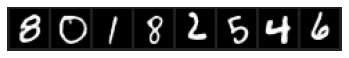

tensor([8, 0, 1, 8, 2, 5, 4, 6])


In [107]:
demo_autoencoder()

## Выводы сравнения

Мы видем что увелечение размера latent space-а очевидно увеличевает качество энкодера, но в какйто момент прогресс замедляется.
Вот 25 и 50 находяться почти на одном уровне, а 2 выглядит ужасно даже на уровне картинок. 
Он путает 5ки и 8ки, и всместо красивых чётких цыфр, выдаёт зармазанные кляксы.
Мне кажется что оптимальный размер тут 25, но я ещё проверю 20 и 15.
Ещё тренеровать эти сети по 30 эпох не особо полезно, поэтому я дальше буду тренировать по 10, чтобы экономить время. 

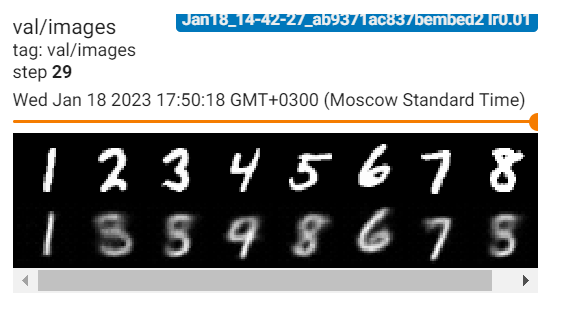

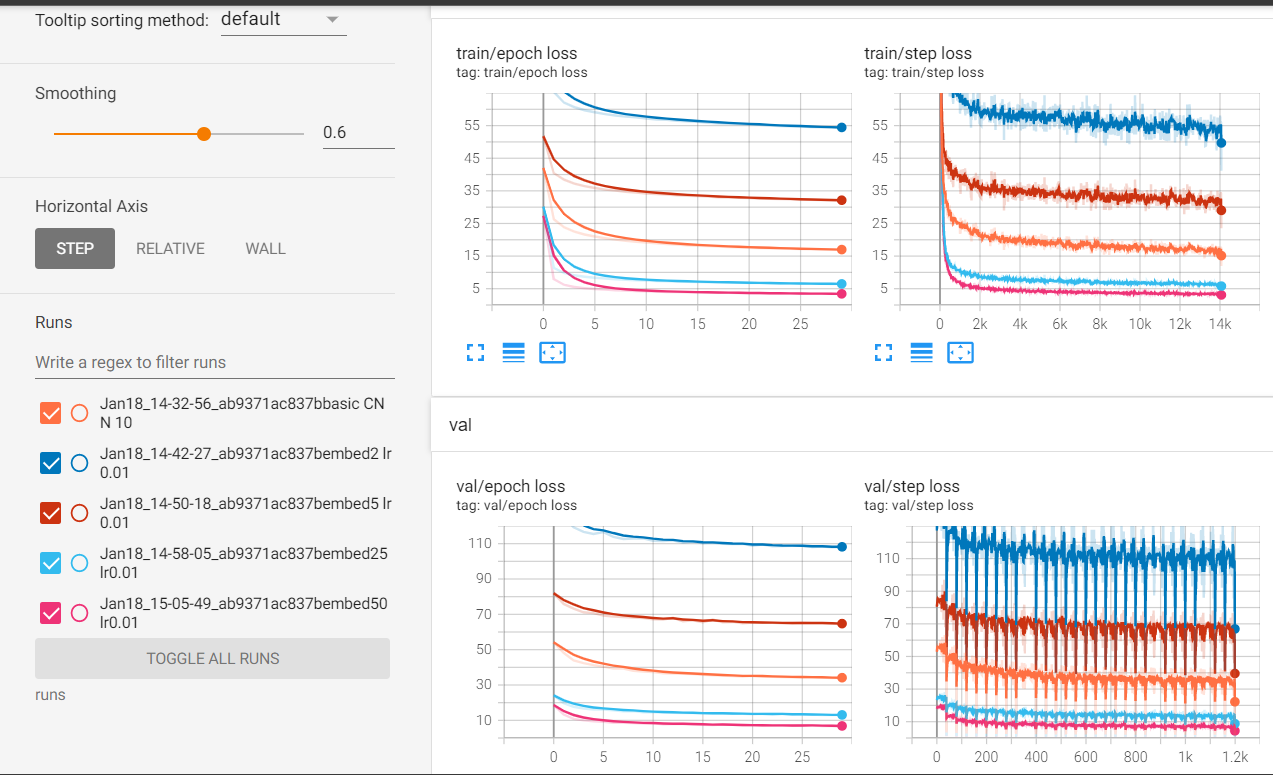

# Пробоем чистить шум

Original:


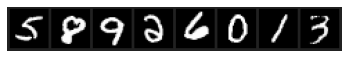

Noisy:


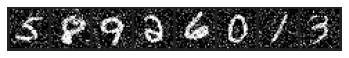

Reconstructed:


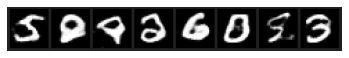

tensor([5, 8, 9, 2, 6, 0, 1, 3])


In [120]:
def demo_noise(factor=1):
  orig, labels = next(dataiter)

  # display the data
  print("Original:")
  show(torchvision.utils.make_grid(orig))

  print("Noisy:")
  noisy = orig + torch.randn((8,1,28,28)) * factor
  show(torchvision.utils.make_grid(noisy))

  print("Reconstructed:")
  reconstructed = torchvision.utils.make_grid(model(noisy.to(device))[0])
  show(reconstructed.cpu())
  print(labels)

demo_noise()

Както неочень... 
Я ожидал большего.
Шум пропал, но цыфры стали сильно меньше похожи на самих себя.
А некоторые вообще стали другими цыфрами.
Может быть надо попробывать с другими моделями

In [ ]:
reset_model(32)
train(60)

Original:


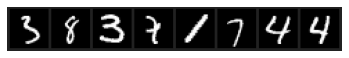

Noisy:


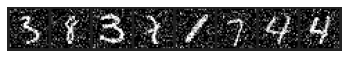

Reconstructed:


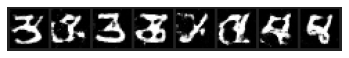

tensor([3, 8, 3, 7, 1, 7, 4, 4])


In [122]:
demo_noise()

С большой моделью получилось ещё хуже... Кажется он оверфитится. Наверно надо попробывать маленькую

In [ ]:
reset_model(8)
train(20)

Original:


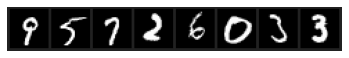

Noisy:


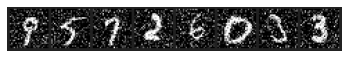

Reconstructed:


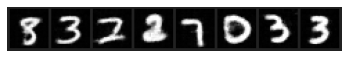

tensor([9, 5, 7, 2, 6, 0, 3, 3])


In [124]:
demo_noise()

Действительно маленькая модель тут лучше, но она всеравно путает цыфры

# Пробоем арифметику


Четвёрки:


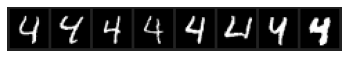

Средняя четвёрка:


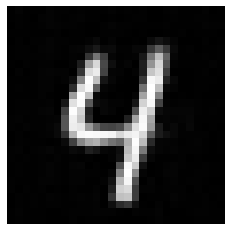

In [151]:
def show_grid(x):
  show(torchvision.utils.make_grid(x))

with torch.no_grad():
  mega_loader = DataLoader(test_dataset, batch_size=len(test_dataset))
  all_images, all_labels = next(iter(mega_loader))
  _, embeddings = model(all_images.to(device))

label = 4
print("Четвёрки:")
show_grid(all_images[all_labels == label][:8])

print("Средняя четвёрка:")
show_grid(model.decoder(embeddings[all_labels == label].mean(0, keepdim=True)).cpu())

Единица наоборот:


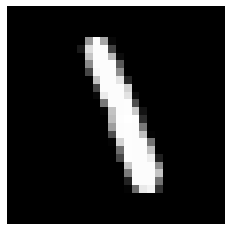

Обычная четвёрка:


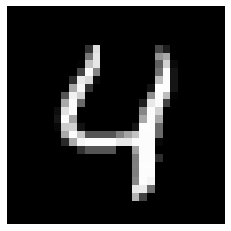

Новая четвёрка:


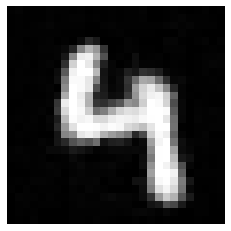

Единица отзеркаленая:


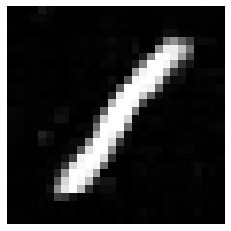

In [173]:
print("Единица наоборот:")
show_grid(all_images[all_labels == 1][8])

print("Обычная четвёрка:")
show_grid(all_images[all_labels == 4][0])

mean_one = embeddings[all_labels == 1].mean(0, keepdim=True)
tilted_one = embeddings[all_labels == 1][8:9]
tilt = tilted_one - mean_one
normal_four = embeddings[all_labels == 4][0:1]
tilted_four = normal_four + tilt

print("Новая четвёрка:")
show_grid(model.decoder(tilted_four).cpu())

print("Единица отзеркаленая:")
show_grid(model.decoder(tilted_one - tilt * 2).cpu())

Плавный наклон 1:


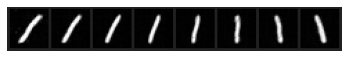

Плавный наклон 3:


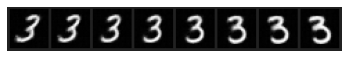

Плавный наклон 4:


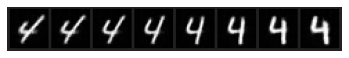

Плавный наклон 5:


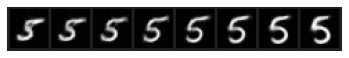

Плавный наклон 0:


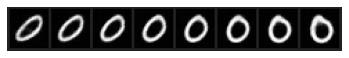

In [202]:
def tilt_gradient(number_1=1):
  mean_one = embeddings[all_labels == number_1].mean(0, keepdim=True)
  linspace = torch.linspace(-1,.8,8).to(device).reshape((8,1))
  res = mean_one + tilt*linspace

  print(f"Плавный наклон {number_1}:")
  show_grid(model.decoder(res).cpu())

tilt_gradient(1)
tilt_gradient(3)
tilt_gradient(4)
tilt_gradient(5)
tilt_gradient(0)

Гдариент от 1 до 7:


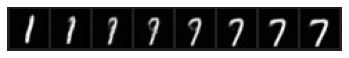

Гдариент от 3 до 5:


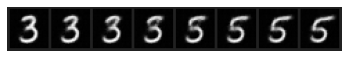

Гдариент от 4 до 9:


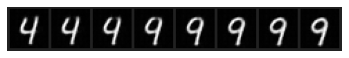

Гдариент от 6 до 0:


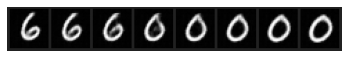

Гдариент от 1 до 0:


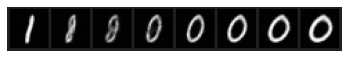

Гдариент от 5 до 9:


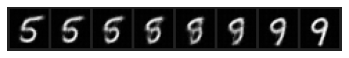

In [187]:
def interpolate(number_1=1, number_2=7):
  mean_one = embeddings[all_labels == number_1].mean(0, keepdim=True)
  mean_seven = embeddings[all_labels == number_2].mean(0, keepdim=True)
  delta = mean_seven - mean_one
  linspace = torch.linspace(0,1,8).to(device).reshape((8,1))
  res = mean_one + delta*linspace

  print(f"Гдариент от {number_1} до {number_2}:")
  show_grid(model.decoder(res).cpu())

interpolate(1,7)
interpolate(3,5)
interpolate(4,9)
interpolate(6,0)
interpolate(1,0)
interpolate(5,9)

Градиенты очень красивые, и по пути от 1 до 0 он пересекает 8.
Это можно даже заметить на скатер плоте эмбединга, который был у нас давным давно.

2d градиент:


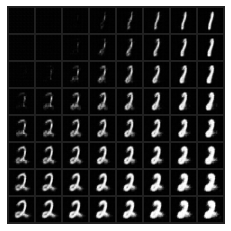

In [222]:
zero = torch.zeros((model.latent_size,1)).to(device)
mean_one = embeddings[all_labels == 1].mean(0, keepdim=True)
mean_two = embeddings[all_labels == 2].mean(0, keepdim=True)
linspace = torch.linspace(0,1,8).to(device).reshape((8,1))

res = []
for i in torch.linspace(0,1,8):
  res.append(zero + mean_one*linspace + mean_two*i)
res= torch.cat(res, dim=0)

print("2d градиент:")
show_grid(model.decoder(res).cpu())

# Conclusion

Сравинивать разные автоэнкодоры довольно сложно, по сравнению с например классификаторами, потому что у них нету очевидного способа оценки качества результата, как например accuracy.
Мы можем только глазками смотреть на то, насколько они портят изображения, и на тот loss, по которому они обучались. 
Можно былобы наеврное придумать систему, где у нас есть ещё дополнительны классификатор, который достаточно иедально работает на данном датасете, и мы бы могли использовать его для оценки accuracy автоэнкодера. Например, можно было бы смотреть на процент картинок, которые после прогона через автоэнкодер меняют свой класс.
Также может быть идея опятьтаки глазками смотреть на эмбеддинг и качество кластеров в нём, но это мы опять вспоминаем про то что у нас датасет с лейблами.
Если бы лейблов небыло, то все мои гениальные идеи не работали бы...

# Ideas for extra work

* Find the best latent space size
* Implement noise filtration with AE
* Test vector arithmetic in laent space
* Implemet VAE 
** Use Autoencoder class as base class
** Implement VAE Loss class
** Plot embeddings manifold in VAE latent space
** Compare decoding results VAE latent space with vanilla Autoencoder results
* Replace reconstruction loss from MSE to BCE
* Implement Conditional Autoencoder or CVAE